# With-without mask milestone

# Prepare Environment

In [20]:
# Set the random seed number for reproducible results
seedNum = 1

In [29]:
# Load libraries and packages
import random
random.seed(seedNum)
import numpy as np
np.random.seed(seedNum)
import tensorflow as tf
tf.random.set_seed(seedNum)
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
import pandas as pd
import math
import os
import sys
import shutil
import urllib.request
import zipfile
import smtplib
from matplotlib import pyplot
from matplotlib.image import imread
from datetime import datetime
from email.message import EmailMessage

In [22]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
	fig, axs = pyplot.subplots(2, 1, figsize=(12,12))
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='red', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Classification Accuracy')
	pyplot.plot(history.history['accuracy'], color='blue', label='train')
	pyplot.plot(history.history['val_accuracy'], color='red', label='test')
	pyplot.show()

In [23]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
n_jobs = -1
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set up the mountStorage flag to mount G Drive for storing files (setting True will mount the drive!)
mountStorage = False

Num GPUs Available:  0


In [24]:
# Set the default optimizer for the remaining portion of the script
default_opt = Adam(learning_rate=0.001)

# Data Preparation

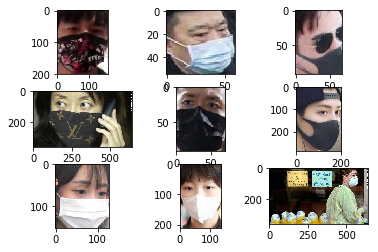

In [25]:
# plot with mask photos from with mask vs without mask dataset

# define location of dataset
folder = 'train/'
# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# define filename
	filename = folder + 'with_mask_' + str(i) + '.jpg'
	# load image pixels
	image = imread(filename)
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

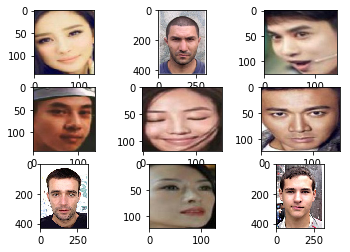

In [26]:
# plot without mask photos from with mask vs without mask dataset

# define location of dataset
folder = 'train/'
# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# define filename
	filename = folder + 'without_mask_' + str(i) + '.jpg'
	# load image pixels
	image = imread(filename)
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

In [27]:
# organize dataset into a useful structure
from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
from random import random
# create directories
dataset_home = 'dataset_with_mask_vs_without_mask/'
subdirs = ['train/', 'test/']
for subdir in subdirs:
	# create label subdirectories
	labeldirs = ['with_mask/', 'without_mask/']
	for labldir in labeldirs:
		newdir = dataset_home + subdir + labldir
		makedirs(newdir, exist_ok=True)
# seed random number generator
seed(seedNum)
# define ratio of pictures to use for validation
val_ratio = 0.25
# copy training dataset images into subdirectories
src_directory = 'train/'
for file in listdir(src_directory):
	src = src_directory + '/' + file
	dst_dir = 'train/'
	if random() < val_ratio:
		dst_dir = 'test/'
	if file.startswith('without_mask'):
		dst = dataset_home + dst_dir + 'without_mask/'  + file
		copyfile(src, dst)
	elif file.startswith('with_mask'):
		dst = dataset_home + dst_dir + 'with_mask/'  + file
		copyfile(src, dst)

## Fit and Evaluate Models

Found 2865 images belonging to 2 classes.
Found 970 images belonging to 2 classes.
Epoch 1/10
45/45 [==============================] - 104s 2s/step - loss: 13.0417 - accuracy: 0.7843 - val_loss: 0.4839 - val_accuracy: 0.8381
Epoch 2/10
45/45 [==============================] - 92s 2s/step - loss: 0.2261 - accuracy: 0.9253 - val_loss: 0.2905 - val_accuracy: 0.9175
Epoch 3/10
45/45 [==============================] - 88s 2s/step - loss: 0.0898 - accuracy: 0.9731 - val_loss: 0.2168 - val_accuracy: 0.9423
Epoch 4/10
45/45 [==============================] - 88s 2s/step - loss: 0.0443 - accuracy: 0.9885 - val_loss: 0.2030 - val_accuracy: 0.9433
Epoch 5/10
45/45 [==============================] - 94s 2s/step - loss: 0.0222 - accuracy: 0.9955 - val_loss: 0.1988 - val_accuracy: 0.9536
Epoch 6/10
45/45 [==============================] - 109s 2s/step - loss: 0.0121 - accuracy: 0.9976 - val_loss: 0.2113 - val_accuracy: 0.9505
Epoch 7/10
45/45 [==============================] - 79s 2s/step - loss: 0.

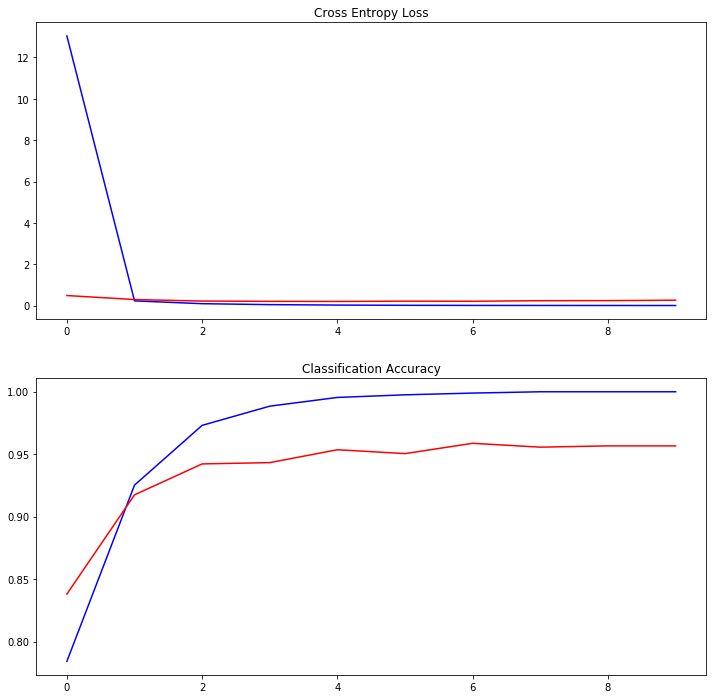

Total time for the model processing: 0:15:48.066835


In [34]:
# baseline model with One Block VGG Model
startTimeModule = datetime.now()
tf.random.set_seed(seedNum)

# define cnn model
def define_model1():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	model.compile(optimizer=default_opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

# run the test harness for evaluating a model
def run_test_harness():
	# define model
	model1 = define_model1()
	# create data generator
	datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterators
	train_it = datagen.flow_from_directory('dataset_with_mask_vs_without_mask/train/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	test_it = datagen.flow_from_directory('dataset_with_mask_vs_without_mask/test/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	# fit model
	history = model1.fit(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=10, verbose=1)
	# evaluate model
	_, acc = model1.evaluate(test_it, steps=len(test_it), verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)
	return model1

# entry point, run the test harness
model_trained = run_test_harness()
print('Total time for the model processing:', (datetime.now() - startTimeModule))

In [62]:
# Test single image
img = load_img('other_tests/trump.jpg', target_size = (200, 200))
img = img_to_array(img)
img = np.expand_dims(img, axis = 0)

model_trained.predict(img)

array([[1.]], dtype=float32)

In [ ]:
# End for milestone?

In [ ]:
# baseline model with Two Block VGG Model
startTimeModule = datetime.now()
tf.random.set_seed(seedNum)

# define cnn model
def define_model2():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	model.compile(optimizer=default_opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

# run the test harness for evaluating a model
def run_test_harness():
	# define model
	model2 = define_model2()
	# create data generator
	datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterators
	train_it = datagen.flow_from_directory('dataset_with_mask_vs_without_mask/train/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	test_it = datagen.flow_from_directory('dataset_with_mask_vs_without_mask/test/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	# fit model
	history = model2.fit(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=1)
	# evaluate model
	_, acc = model2.evaluate(test_it, steps=len(test_it), verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)

# entry point, run the test harness
run_test_harness()
print('Total time for the model processing:', (datetime.now() - startTimeModule))

In [ ]:
# baseline model with Three Block VGG Model
startTimeModule = datetime.now()
tf.random.set_seed(seedNum)

# define cnn model
def define_model3():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	model.compile(optimizer=default_opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

# run the test harness for evaluating a model
def run_test_harness():
	# define model
	model3 = define_model3()
	# create data generator
	datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterators
	train_it = datagen.flow_from_directory('dataset_with_mask_vs_without_mask/train/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	test_it = datagen.flow_from_directory('dataset_with_mask_vs_without_mask/test/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	# fit model
	history = model3.fit(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=1)
	# evaluate model
	_, acc = model3.evaluate(test_it, steps=len(test_it), verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)

# entry point, run the test harness
run_test_harness()
print('Total time for the model processing:', (datetime.now() - startTimeModule))

In [ ]:
# baseline model with VGG-3 and dropout (variation #1)
startTimeModule = datetime.now()
tf.random.set_seed(seedNum)

# define cnn model
def define_model4():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dropout(0.5))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	model.compile(optimizer=default_opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

# run the test harness for evaluating a model
def run_test_harness():
	# define model
	model4 = define_model4()
	# create data generator
	datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterator
	train_it = datagen.flow_from_directory('dataset_with_mask_vs_without_mask/train/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	test_it = datagen.flow_from_directory('dataset_with_mask_vs_without_mask/test/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	# fit model
	history = model4.fit(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=50, verbose=1)
	# evaluate model
	_, acc = model4.evaluate(test_it, steps=len(test_it), verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)

# entry point, run the test harness
run_test_harness()
print('Total time for the model processing:', (datetime.now() - startTimeModule))

In [ ]:
# baseline model with VGG-3 and dropout (variation #2)
startTimeModule = datetime.now()
tf.random.set_seed(seedNum)

# define cnn model
def define_model5():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.3))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dropout(0.5))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	model.compile(optimizer=default_opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

# run the test harness for evaluating a model
def run_test_harness():
	# define model
	model5 = define_model5()
	# create data generator
	datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterator
	train_it = datagen.flow_from_directory('dataset_with_mask_vs_without_mask/train/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	test_it = datagen.flow_from_directory('dataset_with_mask_vs_without_mask/test/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	# fit model
	history = model5.fit(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=50, verbose=1)
	# evaluate model
	_, acc = model5.evaluate(test_it, steps=len(test_it), verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)

# entry point, run the test harness
run_test_harness()
print('Total time for the model processing:', (datetime.now() - startTimeModule))

In [ ]:
# baseline model with VGG-3 and image data augmentation
startTimeModule = datetime.now()
tf.random.set_seed(seedNum)

# define cnn model
def define_model6():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	model.compile(optimizer=default_opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

# run the test harness for evaluating a model
def run_test_harness():
	# define model
	model6 = define_model6()
	# create data generators
	train_datagen = ImageDataGenerator(rescale=1.0/255.0,
		width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
	test_datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterators
	train_it = train_datagen.flow_from_directory('dataset_with_mask_vs_without_mask/train/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	test_it = test_datagen.flow_from_directory('dataset_with_mask_vs_without_mask/test/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	# fit model
	history = model6.fit(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=50, verbose=1)
	# evaluate model
	_, acc = model6.evaluate(test_it, steps=len(test_it), verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)

# entry point, run the test harness
run_test_harness()
print('Total time for the model processing:', (datetime.now() - startTimeModule))

In [ ]:
# baseline model with VGG-3, dropout, and image data augmentation
startTimeModule = datetime.now()
tf.random.set_seed(seedNum)

# define cnn model
def define_model7():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.3))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dropout(0.5))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	model.compile(optimizer=default_opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

# run the test harness for evaluating a model
def run_test_harness():
	# define model
	model7 = define_model7()
	# create data generators
	train_datagen = ImageDataGenerator(rescale=1.0/255.0,
		width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
	test_datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterators
	train_it = train_datagen.flow_from_directory('dataset_with_mask_vs_without_mask/train/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	test_it = test_datagen.flow_from_directory('dataset_with_mask_vs_without_mask/test/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	# fit model
	history = model7.fit(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=50, verbose=1)
	# evaluate model
	_, acc = model7.evaluate(test_it, steps=len(test_it), verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)

# entry point, run the test harness
run_test_harness()
print('Total time for the model processing:', (datetime.now() - startTimeModule))